In [2]:
!pip install boto3 -q
!pip install h5py -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.4 MB/s eta 0:00:00


## Setup & Data Loading

In [3]:
# ============================================================
# SETUP & DATA LOADING
# ============================================================

import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata

# S3 setup
s3 = boto3.client(
    's3',
    aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY'),
    region_name='us-west-2'
)

BUCKET = 'mids-capstone-music-ad-matching-2026'

# Download datasets from S3
print("Downloading datasets from S3...")
s3.download_file(BUCKET, 'processed-data/million_song_10k_subset.csv', 'songs.csv')
s3.download_file(BUCKET, 'processed-data/million_song_10k_subset_segments.csv', 'segments.csv')

# Load data
df_songs = pd.read_csv('songs.csv')
df_segments = pd.read_csv('segments.csv')

print(f"Songs: {df_songs.shape}")
print(f"Segments: {df_segments.shape}")

Songs: (10000, 28)
Segments: (8577406, 28)


## Song-Level EDA

In [4]:
# ============================================================
# 1.1) SONG-LEVEL EDA - DATA QUALITY
# ============================================================

print("="*60)
print("DATA QUALITY CHECK")
print("="*60)

# Missing values
print("\nMissing Values:")
missing = df_songs.isnull().sum()
missing_pct = (missing / len(df_songs) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Missing %': missing_pct.values
}).sort_values('Missing %', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

# Basic stats
print("\nDataset Shape:", df_songs.shape)
print("\nColumn Types:")
print(df_songs.dtypes)

# Sample rows
print("\nFirst 3 rows:")
print(df_songs.head(3))

DATA QUALITY CHECK

Missing Values:
                Column  Missing Count  Missing %
12               genre          10000     100.00
8     artist_longitude           6258      62.58
7      artist_latitude           6258      62.58
11     song_hotttnesss           4352      43.52
6      artist_location           4292      42.92
26        artist_terms              5       0.05
9   artist_familiarity              4       0.04
4                title              1       0.01

Dataset Shape: (10000, 28)

Column Types:
track_id                      object
song_id                       object
artist_id                     object
artist_name                   object
title                         object
release                       object
artist_location               object
artist_latitude              float64
artist_longitude             float64
artist_familiarity           float64
artist_hotttnesss            float64
song_hotttnesss              float64
genre                        float64


Summary Statistics:
           duration         tempo      loudness  danceability   energy  \
count  10000.000000  10000.000000  10000.000000       10000.0  10000.0   
mean     238.507518    122.915449    -10.485668           0.0      0.0   
std      114.137514     35.184412      5.399788           0.0      0.0   
min        1.044440      0.000000    -51.643000           0.0      0.0   
25%      176.032200     96.965750    -13.163250           0.0      0.0   
50%      223.059140    120.161000     -9.380000           0.0      0.0   
75%      276.375060    144.013250     -6.532500           0.0      0.0   
max     1819.767710    262.828000      0.566000           0.0      0.0   

       key_confidence  mode_confidence  time_signature_confidence  \
count    10000.000000     10000.000000               10000.000000   
mean         0.449573         0.477784                   0.509937   
std          0.274974         0.191254                   0.373409   
min          0.000000         0.0000

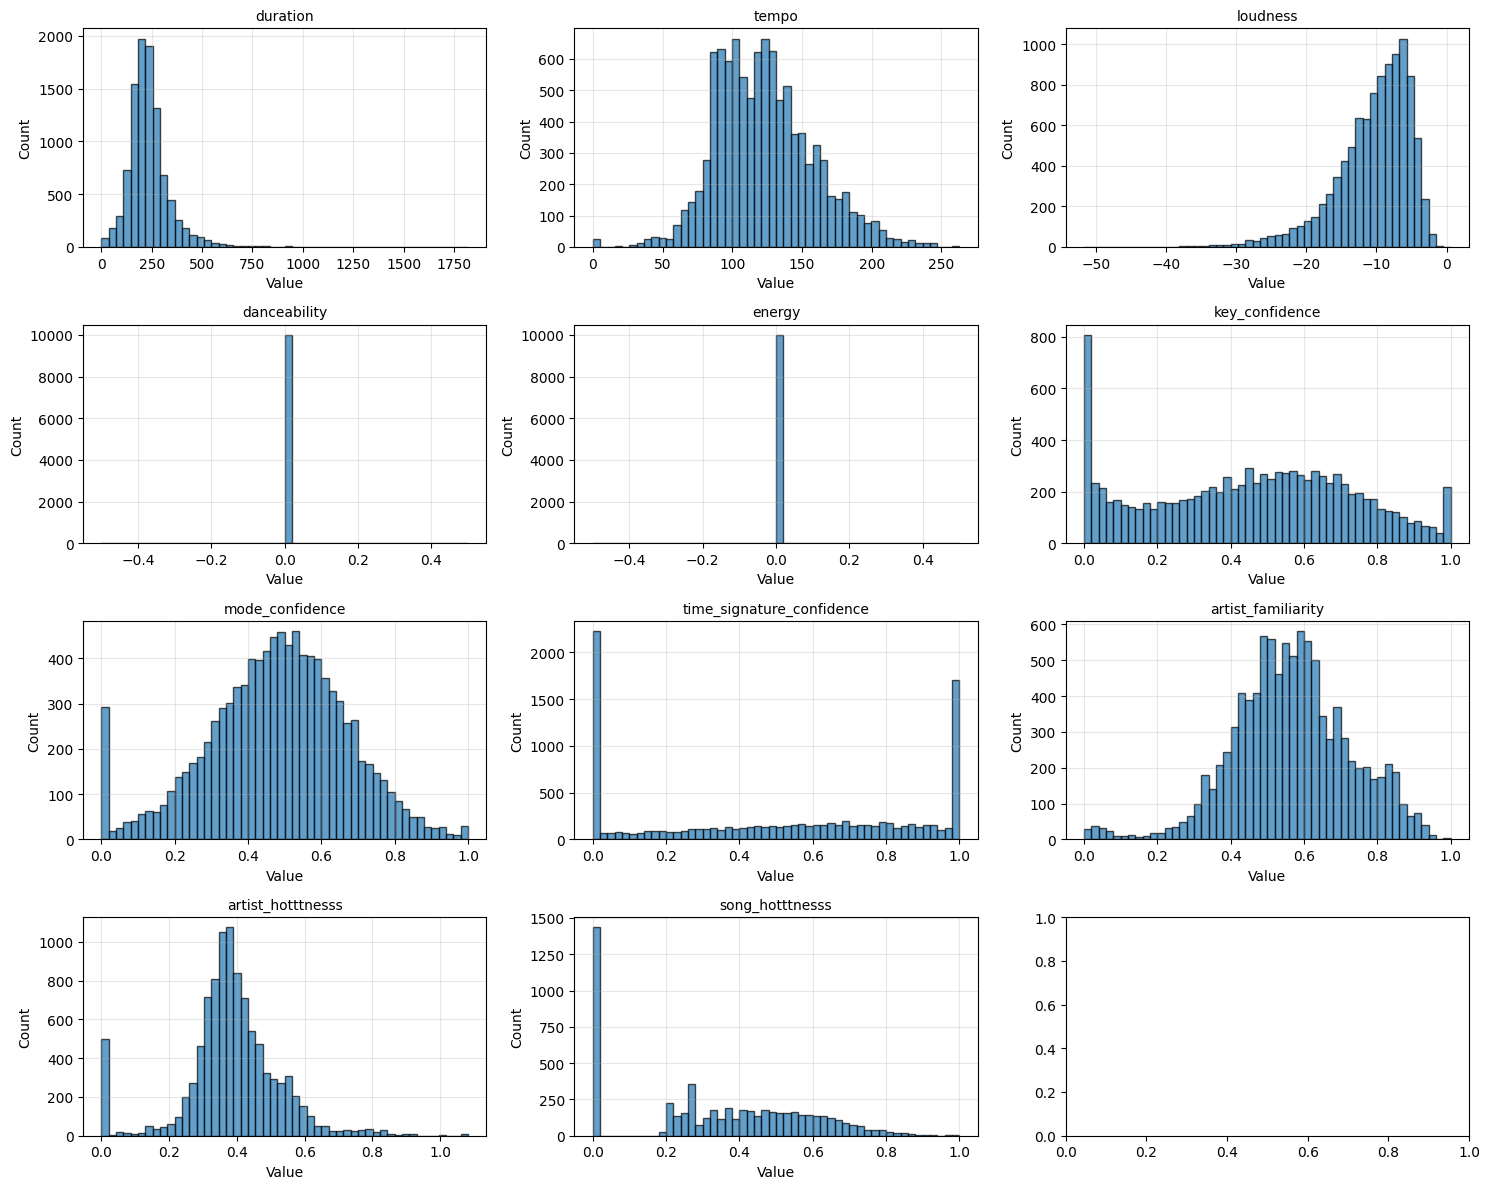

✓ Saved: feature_distributions.png


In [5]:
# ============================================================
# 1.2) SONG-LEVEL EDA - FEATURE DISTRIBUTIONS
# ============================================================

# Numeric features to analyze
numeric_features = ['duration', 'tempo', 'loudness', 'danceability',
                   'energy', 'key_confidence', 'mode_confidence',
                   'time_signature_confidence', 'artist_familiarity',
                   'artist_hotttnesss', 'song_hotttnesss']

# Summary statistics
print("\nSummary Statistics:")
print(df_songs[numeric_features].describe())

# Histograms
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numeric_features):
    if col in df_songs.columns:
        axes[idx].hist(df_songs[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(col, fontsize=10)
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Count')
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: feature_distributions.png")

In [6]:
import h5py
import boto3
import h5py
from google.colab import userdata

s3 = boto3.client(
    's3',
    aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY'),
    region_name='us-west-2'
)

BUCKET = 'mids-capstone-music-ad-matching-2026'

# Download one HDF5 file
response = s3.list_objects_v2(Bucket=BUCKET, Prefix='raw-data/million-song/', MaxKeys=10)
for obj in response.get('Contents', []):
    if obj['Key'].endswith('.h5'):
        sample_key = obj['Key']
        print(f"Downloading: {sample_key}")
        s3.download_file(BUCKET, sample_key, 'sample.h5')
        break

# Check danceability and energy
with h5py.File('sample.h5', 'r') as f:
    print("\nChecking analysis/songs fields:")
    print(f"  danceability: {f['analysis/songs']['danceability'][0]}")
    print(f"  energy: {f['analysis/songs']['energy'][0]}")
    print(f"  tempo: {f['analysis/songs']['tempo'][0]}")
    print(f"  loudness: {f['analysis/songs']['loudness'][0]}")

Downloading: raw-data/million-song/MillionSongSubset/A/A/A/TRAAAAW128F429D538.h5

Checking analysis/songs fields:
  danceability: 0.0
  energy: 0.0
  tempo: 92.198
  loudness: -11.197


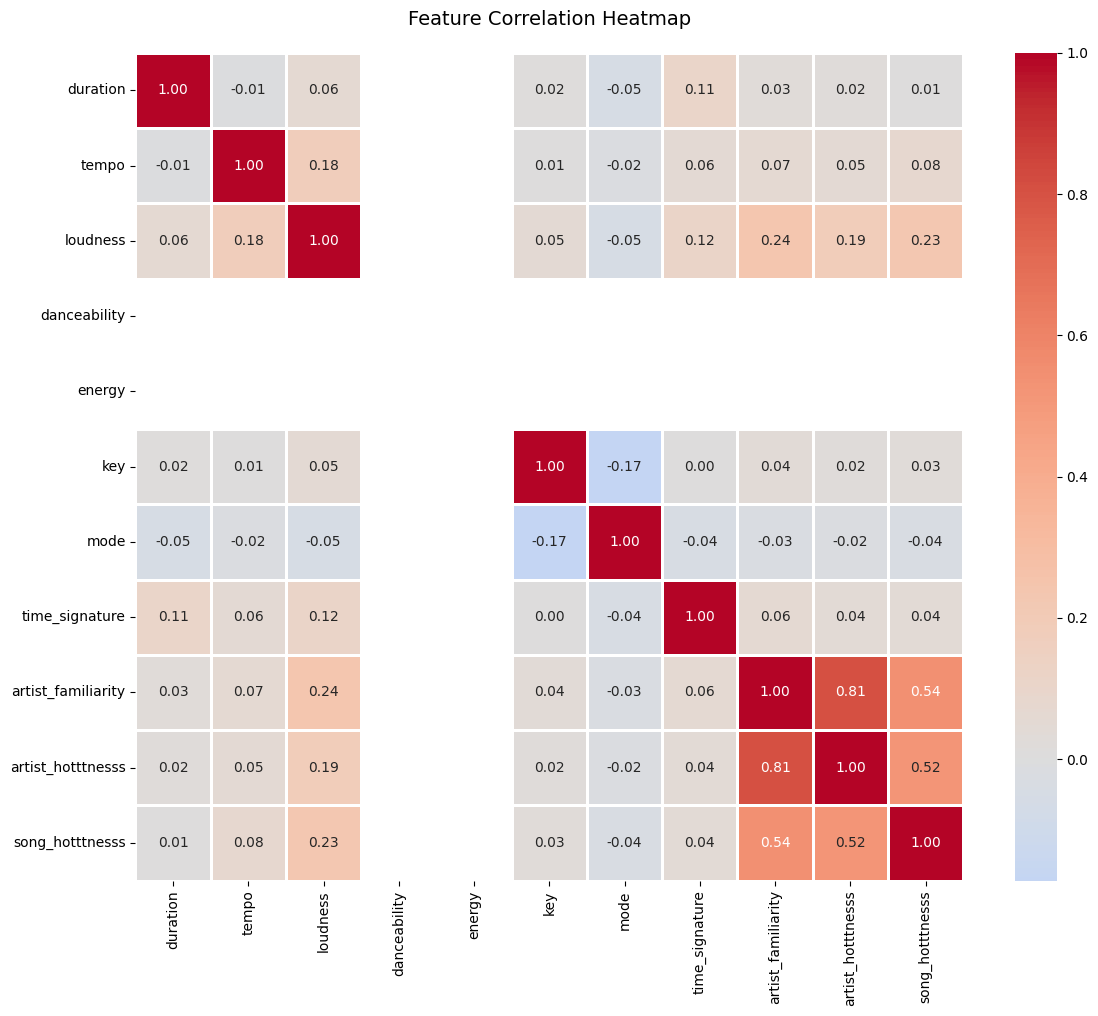

✓ Saved: correlation_heatmap.png

High Correlations (|r| > 0.7):
  artist_familiarity <-> artist_hotttnesss: 0.811


In [7]:
# ============================================================
# 1.3) SONG-LEVEL EDA - CORRELATION HEATMAP
# ============================================================

# Select numeric columns for correlation
corr_features = ['duration', 'tempo', 'loudness', 'danceability',
                'energy', 'key', 'mode', 'time_signature',
                'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss']

# Calculate correlation
corr_matrix = df_songs[corr_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: correlation_heatmap.png")

# Identify high correlations (>0.7 or <-0.7)
print("\nHigh Correlations (|r| > 0.7):")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append((corr_matrix.columns[i],
                            corr_matrix.columns[j],
                            corr_matrix.iloc[i, j]))
for pair in high_corr:
    print(f"  {pair[0]} <-> {pair[1]}: {pair[2]:.3f}")

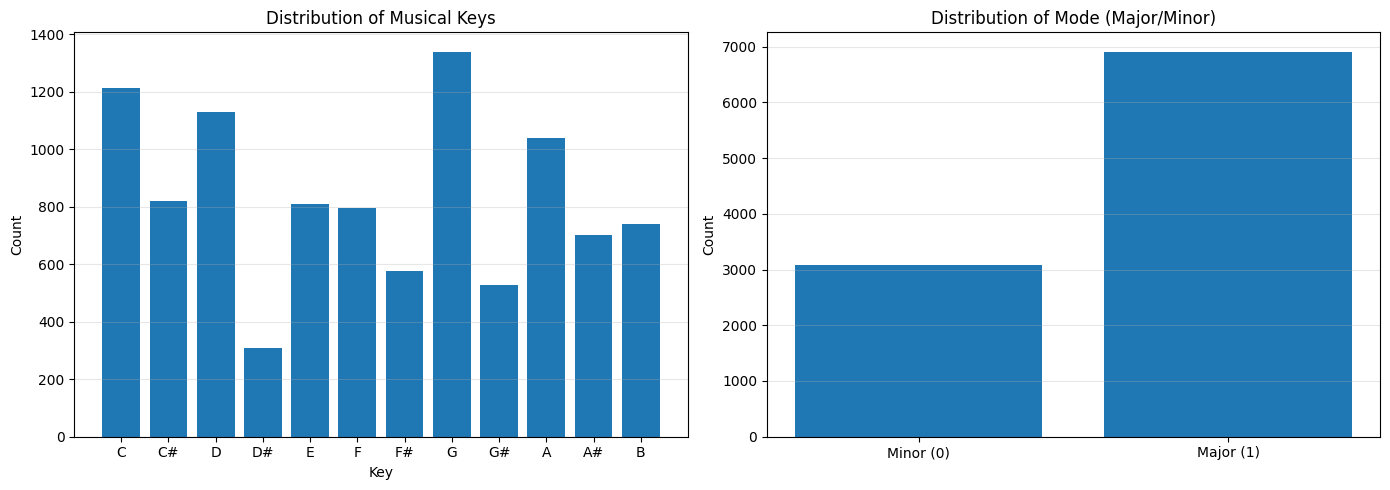

✓ Saved: key_mode_distribution.png


In [8]:
# ============================================================
# 1.4) SONG-LEVEL EDA - KEY/MODE DISTRIBUTION
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Key distribution
key_counts = df_songs['key'].value_counts().sort_index()
key_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
axes[0].bar(range(12), [key_counts.get(i, 0) for i in range(12)])
axes[0].set_xticks(range(12))
axes[0].set_xticklabels(key_names)
axes[0].set_title('Distribution of Musical Keys')
axes[0].set_xlabel('Key')
axes[0].set_ylabel('Count')
axes[0].grid(alpha=0.3, axis='y')

# Mode distribution
mode_counts = df_songs['mode'].value_counts()
axes[1].bar(['Minor (0)', 'Major (1)'], [mode_counts.get(0, 0), mode_counts.get(1, 0)])
axes[1].set_title('Distribution of Mode (Major/Minor)')
axes[1].set_ylabel('Count')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('key_mode_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: key_mode_distribution.png")

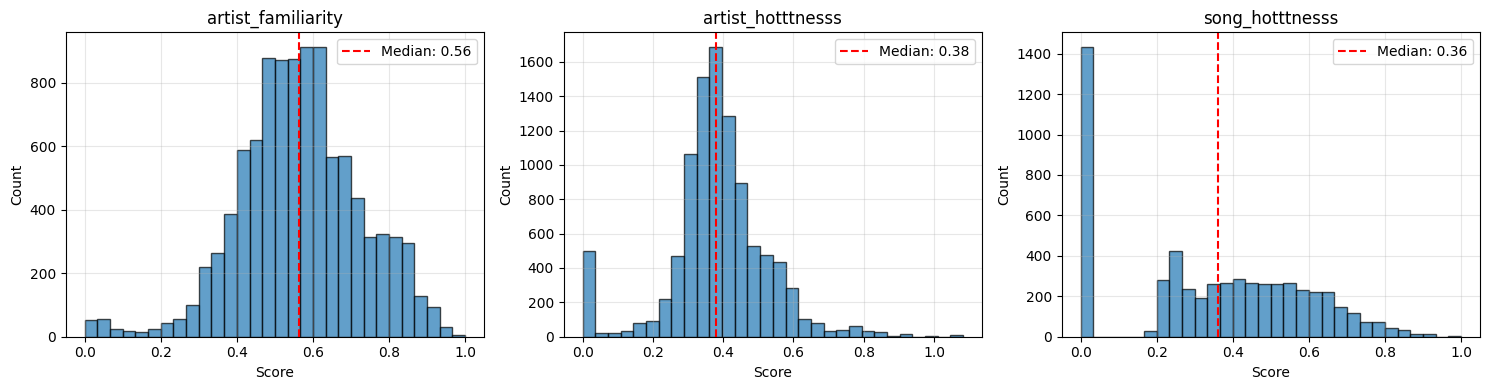


Total unique artists: 4412
Total tracks: 10000

Top 10% of artists (441 artists):
  Account for 2803 tracks (28.0% of total)

Top 10 artists by track count:
artist_name
Mario Rosenstock             13
Sugar Minott                 12
Phil Collins                 12
Aerosmith                    12
The Jackson Southernaires    12
Bill & Gloria Gaither        11
Nick Cave & The Bad Seeds    11
Radiohead                    11
Line Renaud                  11
Snow Patrol                  11
Name: count, dtype: int64

Tags appearing in 100+ songs: 444
Tags appearing in <5 songs: 1412


In [18]:
# ============================================================
# 1.5) SONG-LEVEL EDA - POPULARITY & ARTIST/TAG CONCENTRATION
# ============================================================

# Popularity tiers
popularity_features = ['artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, col in enumerate(popularity_features):
    data = df_songs[col].dropna()
    axes[idx].hist(data, bins=30, edgecolor='black', alpha=0.7)
    axes[idx].axvline(data.median(), color='red', linestyle='--',
                     label=f'Median: {data.median():.2f}')
    axes[idx].set_title(col)
    axes[idx].set_xlabel('Score')
    axes[idx].set_ylabel('Count')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('popularity_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Artist concentration
artist_track_counts = df_songs['artist_name'].value_counts()
print(f"\nTotal unique artists: {len(artist_track_counts)}")
print(f"Total tracks: {len(df_songs)}")

top_10pct = int(len(artist_track_counts) * 0.1)
top_artists_tracks = artist_track_counts.head(top_10pct).sum()
concentration = (top_artists_tracks / len(df_songs)) * 100

print(f"\nTop 10% of artists ({top_10pct} artists):")
print(f"  Account for {top_artists_tracks} tracks ({concentration:.1f}% of total)")

print("\nTop 10 artists by track count:")
print(artist_track_counts.head(10))

# Tag frequency analysis
from collections import Counter
all_tags = []
for tags_str in df_songs['artist_terms'].dropna():
    if isinstance(tags_str, str):
        all_tags.extend(tags_str.split('|'))

tag_counts = Counter(all_tags)
print(f"\nTags appearing in 100+ songs: {len([t for t, c in tag_counts.items() if c >= 100])}")
print(f"Tags appearing in <5 songs: {len([t for t, c in tag_counts.items() if c < 5])}")

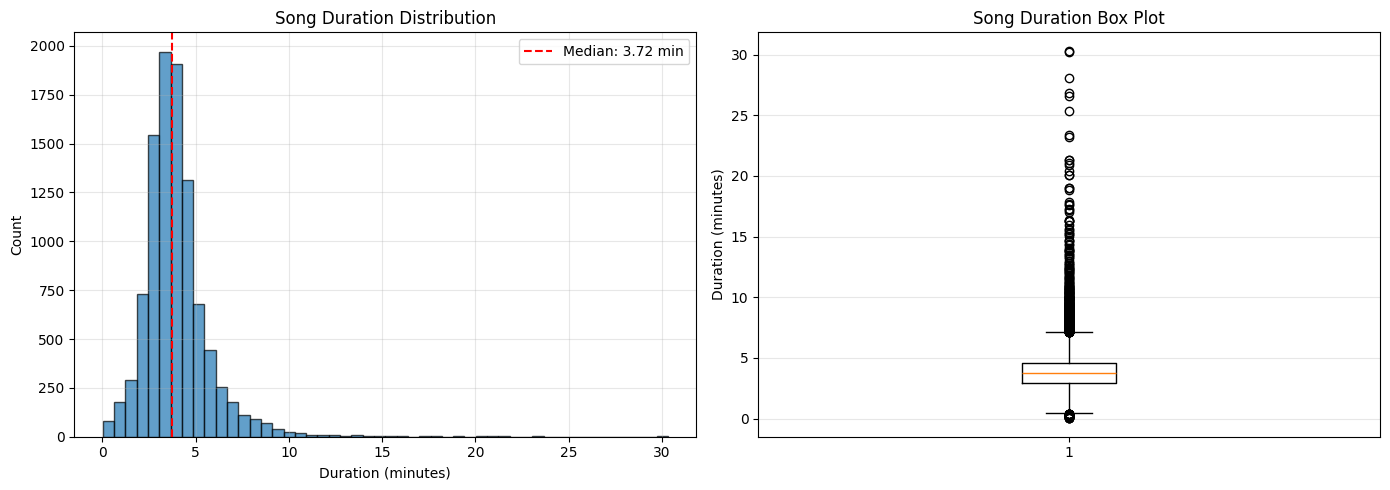


Duration Statistics (minutes):
  Min: 0.02
  25th percentile: 2.93
  Median: 3.72
  75th percentile: 4.61
  Max: 30.33


In [10]:
# ============================================================
# 1.6) SONG-LEVEL EDA - DURATION ANALYSIS
# ============================================================

duration_min = df_songs['duration'] / 60  # Convert to minutes

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
axes[0].hist(duration_min, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(duration_min.median(), color='red', linestyle='--',
               label=f'Median: {duration_min.median():.2f} min')
axes[0].set_title('Song Duration Distribution')
axes[0].set_xlabel('Duration (minutes)')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(duration_min.dropna())
axes[1].set_title('Song Duration Box Plot')
axes[1].set_ylabel('Duration (minutes)')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('duration_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nDuration Statistics (minutes):")
print(f"  Min: {duration_min.min():.2f}")
print(f"  25th percentile: {duration_min.quantile(0.25):.2f}")
print(f"  Median: {duration_min.median():.2f}")
print(f"  75th percentile: {duration_min.quantile(0.75):.2f}")
print(f"  Max: {duration_min.max():.2f}")

In [11]:
# ============================================================
# 1.7) SONG-LEVEL EDA - TAGS ANALYSIS
# ============================================================

# Parse artist_terms (pipe-delimited strings)
all_tags = []
for tags_str in df_songs['artist_terms'].dropna():
    if isinstance(tags_str, str) and len(tags_str) > 0:
        all_tags.extend(tags_str.split('|'))

from collections import Counter
tag_counts = Counter(all_tags)

print(f"\nTotal unique tags: {len(tag_counts)}")
print(f"Total tag instances: {sum(tag_counts.values())}")

print("\nTop 20 most common tags:")
for tag, count in tag_counts.most_common(20):
    print(f"  {tag}: {count}")

# Tag count per song
tags_per_song = df_songs['num_artist_terms'].dropna()
print(f"\nTags per song:")
print(f"  Mean: {tags_per_song.mean():.1f}")
print(f"  Median: {tags_per_song.median():.0f}")
print(f"  Max: {tags_per_song.max():.0f}")


Total unique tags: 3502
Total tag instances: 266611

Top 20 most common tags:
  rock: 6493
  pop: 5476
  electronic: 4453
  jazz: 3596
  united states: 3084
  hip hop: 2926
  alternative rock: 2753
  folk: 2598
  alternative: 2586
  soul: 2491
  pop rock: 2324
  blues: 2281
  country: 2215
  american: 2207
  punk: 2182
  indie: 2167
  guitar: 2163
  funk: 2008
  classic rock: 1985
  acoustic: 1942

Tags per song:
  Mean: 26.7
  Median: 25
  Max: 91


In [12]:
# ============================================================
# 1.8) SONG-LEVEL EDA - GEOGRAPHIC DISTRIBUTION
# ============================================================

# Check completeness
location_complete = df_songs['artist_location'].notna().sum()
location_pct = (location_complete / len(df_songs)) * 100

print(f"\nArtist Location Completeness:")
print(f"  {location_complete} / {len(df_songs)} ({location_pct:.1f}%)")

if location_complete > 0:
    print("\nTop 10 artist locations:")
    print(df_songs['artist_location'].value_counts().head(10))

    # Lat/long completeness
    latlong_complete = (df_songs['artist_latitude'].notna() &
                       df_songs['artist_longitude'].notna()).sum()
    latlong_pct = (latlong_complete / len(df_songs)) * 100
    print(f"\nLat/Long available: {latlong_complete} ({latlong_pct:.1f}%)")


Artist Location Completeness:
  5708 / 10000 (57.1%)

Top 10 artist locations:
artist_location
London, England      149
New York, NY         141
Los Angeles, CA      136
Chicago, IL           69
California - LA       68
Kingston, Jamaica     64
United States         59
Brooklyn, NY          59
Texas                 56
Atlanta, GA           54
Name: count, dtype: int64

Lat/Long available: 3742 (37.4%)


## Segment-Level EDA


SEGMENT-LEVEL ANALYSIS

Segments per song:
  Mean: 858
  Median: 766
  Min: 4
  Max: 8419


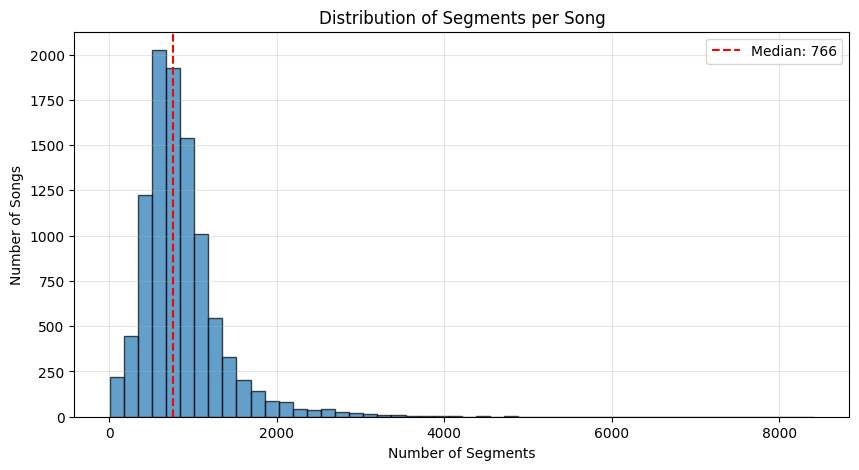

In [13]:
# ============================================================
# 2.1) SEGMENT-LEVEL EDA - STRUCTURE ANALYSIS
# ============================================================

print("\n" + "="*60)
print("SEGMENT-LEVEL ANALYSIS")
print("="*60)

# Segments per song
segments_per_song = df_segments.groupby('song_id').size()

print(f"\nSegments per song:")
print(f"  Mean: {segments_per_song.mean():.0f}")
print(f"  Median: {segments_per_song.median():.0f}")
print(f"  Min: {segments_per_song.min()}")
print(f"  Max: {segments_per_song.max()}")

# Plot distribution
plt.figure(figsize=(10, 5))
plt.hist(segments_per_song, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(segments_per_song.median(), color='red', linestyle='--',
           label=f'Median: {segments_per_song.median():.0f}')
plt.title('Distribution of Segments per Song')
plt.xlabel('Number of Segments')
plt.ylabel('Number of Songs')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('segments_per_song.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# ============================================================
# 2.2) SEGMENT-LEVEL EDA - SEGMENT DURATION
# ============================================================

# Calculate segment durations (time between consecutive segments)
sample_song = df_segments[df_segments['song_id'] == df_segments['song_id'].iloc[0]].copy()
sample_song = sample_song.sort_values('segment_idx')
sample_song['segment_duration'] = sample_song['segment_start'].diff().shift(-1)

avg_segment_duration = sample_song['segment_duration'].mean()
print(f"\nSample song segment duration: {avg_segment_duration:.3f} seconds")

# Check across multiple songs (sample 100)
sample_songs = df_segments['song_id'].unique()[:100]
all_durations = []

for song_id in sample_songs:
    song_segments = df_segments[df_segments['song_id'] == song_id].sort_values('segment_idx')
    durations = song_segments['segment_start'].diff().shift(-1).dropna()
    all_durations.extend(durations.values)

print(f"\nSegment duration statistics (100 songs sample):")
print(f"  Mean: {np.mean(all_durations):.3f} sec")
print(f"  Median: {np.median(all_durations):.3f} sec")
print(f"  Std: {np.std(all_durations):.3f} sec")


Sample song segment duration: 0.226 seconds

Segment duration statistics (100 songs sample):
  Mean: 0.277 sec
  Median: 0.237 sec
  Std: 0.204 sec


/tmp/ipython-input-2009439094.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([timbre_data[col].dropna() for col in timbre_cols],
/tmp/ipython-input-2009439094.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([pitch_data[col].dropna() for col in pitch_cols],


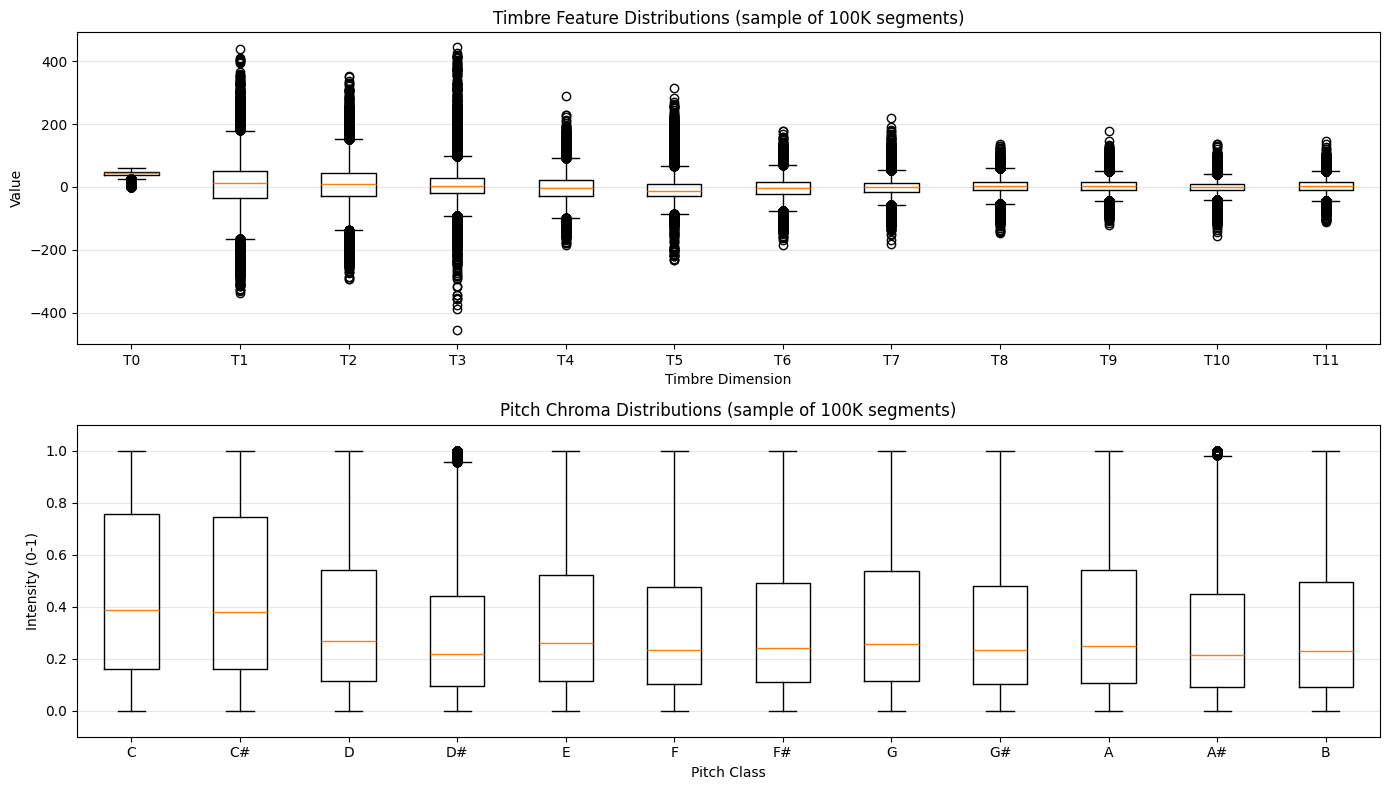

In [15]:
# ============================================================
# 2.3) SEGMENT-LEVEL EDA - TIMBRE/PITCH DISTRIBUTIONS
# ============================================================

# Timbre features
timbre_cols = [f'timbre_{i}' for i in range(12)]
pitch_cols = [f'pitch_{i}' for i in range(12)]

# Sample to make computation faster
sample_segments = df_segments.sample(min(100000, len(df_segments)), random_state=42)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Timbre distributions
timbre_data = sample_segments[timbre_cols]
axes[0].boxplot([timbre_data[col].dropna() for col in timbre_cols],
               labels=[f'T{i}' for i in range(12)])
axes[0].set_title('Timbre Feature Distributions (sample of 100K segments)')
axes[0].set_xlabel('Timbre Dimension')
axes[0].set_ylabel('Value')
axes[0].grid(alpha=0.3, axis='y')

# Pitch distributions (should be [0,1])
pitch_data = sample_segments[pitch_cols]
axes[1].boxplot([pitch_data[col].dropna() for col in pitch_cols],
               labels=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
axes[1].set_title('Pitch Chroma Distributions (sample of 100K segments)')
axes[1].set_xlabel('Pitch Class')
axes[1].set_ylabel('Intensity (0-1)')
axes[1].set_ylim([-0.1, 1.1])
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('segment_features.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# ============================================================
# 2.4) SEGMENT-LEVEL EDA - WITHIN-SONG VARIABILITY
# ============================================================

# Analyze 10 sample songs
sample_song_ids = df_segments['song_id'].unique()[:10]

variability_results = []
for song_id in sample_song_ids:
    song_segs = df_segments[df_segments['song_id'] == song_id]

    timbre_var = song_segs[timbre_cols].std().mean()
    pitch_var = song_segs[pitch_cols].std().mean()
    loudness_var = song_segs['loudness_max'].std()

    variability_results.append({
        'song_id': song_id,
        'num_segments': len(song_segs),
        'timbre_variability': timbre_var,
        'pitch_variability': pitch_var,
        'loudness_variability': loudness_var
    })

var_df = pd.DataFrame(variability_results)
print("\nWithin-song variability (10 sample songs):")
print(var_df)
print(f"\nMean timbre variability: {var_df['timbre_variability'].mean():.2f}")
print(f"Mean pitch variability: {var_df['pitch_variability'].mean():.2f}")


Within-song variability (10 sample songs):
              song_id  num_segments  timbre_variability  pitch_variability  \
0  SOMZWCG12A8C13C480           971           33.854582           0.314206   
1  SOCIWDW12A8C13D406           550           22.058253           0.251791   
2  SOXVLOJ12AB0189215           562           28.336204           0.279430   
3  SONHOTT12A8C13493C           821           23.088449           0.266800   
4  SOFSOCN12A8C143F5D           673           19.633332           0.264764   
5  SOYMRWW12A6D4FAB14           835           23.424467           0.250217   
6  SOMJBYD12A6D4F8557           481           36.271943           0.300894   
7  SOHKNRJ12A6701D1F8           588           27.209275           0.280368   
8  SOIAZJW12AB01853F1           912           20.784325           0.271918   
9  SOUDSGM12AC9618304          1406           35.461104           0.286537   

   loudness_variability  
0              4.825070  
1              5.962799  
2              3.14

## Cross-File Validation

In [17]:
# ============================================================
# 3. CROSS-FILE VALIDATION
# ============================================================

print("\n" + "="*60)
print("CROSS-FILE VALIDATION")
print("="*60)

# Join test
song_ids_songs = set(df_songs['song_id'])
song_ids_segments = set(df_segments['song_id'])

print(f"\nUnique song_ids in songs table: {len(song_ids_songs)}")
print(f"Unique song_ids in segments table: {len(song_ids_segments)}")

# Check if all segment song_ids exist in songs table
missing_in_songs = song_ids_segments - song_ids_songs
if len(missing_in_songs) == 0:
    print("✓ All segment song_ids exist in songs table")
else:
    print(f"✗ {len(missing_in_songs)} song_ids in segments NOT in songs table")

# Check reverse
missing_in_segments = song_ids_songs - song_ids_segments
if len(missing_in_segments) == 0:
    print("✓ All songs have segments")
else:
    print(f"✗ {len(missing_in_segments)} songs have NO segments")

# Test join
merged = df_segments.merge(df_songs, on='song_id', how='left', indicator=True)
print(f"\nJoin test results:")
print(merged['_merge'].value_counts())


CROSS-FILE VALIDATION

Unique song_ids in songs table: 10000
Unique song_ids in segments table: 10000
✓ All segment song_ids exist in songs table
✓ All songs have segments

Join test results:
_merge
both          8577406
left_only           0
right_only          0
Name: count, dtype: int64
